# calculating return periods and values from lmoments

In [28]:
import requests 
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime

import lmoments3 as lm
from lmoments3 import distr

import matplotlib.pyplot as plt
%matplotlib inline

## extracting time series from netcdf file

In [29]:
ds = xr.open_dataset("./data/pr_Amon_NorESM1-M_historical_r1i1p1_185001-200512.nc")
print(ds)

<xarray.Dataset>
Dimensions:    (time: 1872, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/26)
    institution:            Norwegian Climate Centre
    institute_id:           NCC
    experiment_id:          historical
    source:                 NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Oslo-n...
    model_id:               NorESM1-M
    forcing:                GHG, SA, Oz, Sl, Vl, BC, OC
    ...                     ...
    table_id:               Table Amon (27 April 2011) a5a1c518f52ae340313ba0...
    title:                  NorESM1-M mo

In [32]:
# converting precipitation to m/day units

ds["pr"].data = ds["pr"].data * 86.4
ds["pr"].attrs["units"] = 'm/day' 

In [33]:
# getting dataset specifically for defined location
# coordinates for berkeley, california

lat = 37.87
lon = 122.27
ds_berk = ds.sel(lon=lon, lat=lat, method='nearest')

In [34]:
# converting to timeseries dataframe

sr = ds_berk['pr'].to_pandas()
sr.index = sr.index.to_datetimeindex()
df = pd.DataFrame({'time':sr.index, 'pr':sr.values})

/var/folders/bz/l7frggbx71n9k19wxh7hvwsm0000gn/T/ipykernel_14375/1416090827.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sr.index = sr.index.to_datetimeindex()


## using l-moments to calculate likelihood of a return period and value

### preparing data and fitting to gev (generalized extreme value) distribution

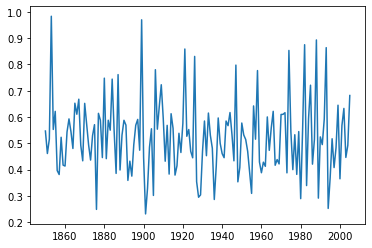

In [35]:
# get annual max series (ams)
# used to fit distribution later

ams = df.groupby([df.time.dt.year])['pr'].max()
plt.plot(ams)

In [36]:
# calculate l-moment ratios

lm_params = lm.lmom_ratios(ams)
lm_params

[0.5233289481928716,
 0.07807944420389246,
 0.10480527006346471,
 0.17371229258781828,
 0.06690049473217287]

In [37]:
# fit to gev distribution

paras = distr.gev.lmom_fit(ams)
fitted_gev = distr.gev(**paras)

### using cdf (cumulative distribution function) to calculate exceedance of values

In [38]:
# assuming the climate has been stationary over historical period
# calculating how likely in a given year it is to experience a 0.009 m/day exceedance
# the probability of exceeding 0.009 m/day in berkeley

1-fitted_gev.cdf(0.009)

0.9999999998858595

### using ppf (inverse distribution function or quantile function) to calculate return period

In [39]:
# what m/day has a probability of being exceeded in a given year of 1%
# calculate the value of a 100 year event 

return_year = 100
return_period = 1.0-1./return_year

fitted_gev.ppf(return_period)

0.9133812830633433

### plotting extreme values according to return years

In [40]:
# calculate return periods for return years 2, 5, 10, 20, 50, 100, 200, 500, and 1000

return_years = [2,5,10,20,50,100,200,500,1000]
return_periods = np.empty(len(return_years))

for i in range(len(return_years)):
    return_periods[i] = 1.0-(1.0/return_years[i])

gev_return_periods = fitted_gev.ppf(return_periods)

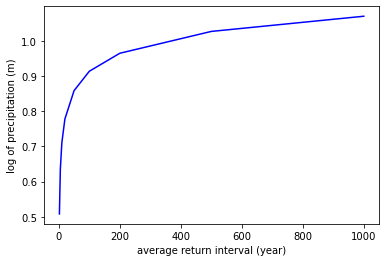

In [41]:
plt.xlabel('average return interval (year)')
plt.ylabel('log of precipitation (m)')

plt.plot(return_years, gev_return_periods, 'b', label='gev')

In [42]:
# calculate return periods for return years (1.1 to 1000)

return_year_range = np.arange(0.1, 999.1, 0.1) + 1
return_period_range = 1.0-(1.0/return_year_range)
gev_return_periods = fitted_gev.ppf(return_period_range)

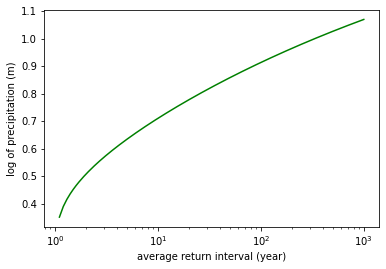

In [43]:
# plot log transformation of return years

plt.xscale('log')
plt.xlabel('average return interval (year)')
plt.ylabel('log of precipitation (m)')

plt.plot(return_year_range, gev_return_periods, 'g', label='gev')

### fitting and plotting to a variety of distributions

In [44]:
# fit to gev (generalized extreme value), gum (gumbel), and wei (weibull) distributions

paras_gev = distr.gev.lmom_fit(ams)
paras_gum = distr.gum.lmom_fit(ams)
paras_wei = distr.wei.lmom_fit(ams)

fitted_gev = distr.gev(**paras_gev)
fitted_gum = distr.gum(**paras_gum)
fitted_wei = distr.wei(**paras_wei)

In [45]:
# calculate return periods for return years (1.1 to 1000)

return_year_range = np.arange(0.1, 999.1, 0.1) + 1
return_period_range = 1.0-(1.0/return_year_range)

In [46]:
# get return period values for different distributions

gev_return_periods = fitted_gev.ppf(return_period_range)
gum_return_periods = fitted_gum.ppf(return_period_range)
wei_return_periods = fitted_wei.ppf(return_period_range)

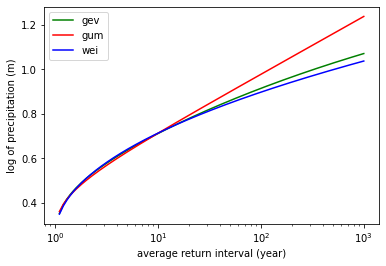

In [47]:
# plot log transformation of return years

plt.xscale('log')
plt.xlabel('average return interval (year)')
plt.ylabel('log of precipitation (m)')

line1, = plt.plot(return_year_range, gev_return_periods, 'g', label='gev')
line2, = plt.plot(return_year_range, gum_return_periods, 'r', label='gum')
line3, = plt.plot(return_year_range, wei_return_periods, 'b', label='wei')

plt.legend()